In [105]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns # for visualization
import matplotlib.pyplot as plt #for visualisation
from sklearn.model_selection import train_test_split #for spliting data and machine learning  
from sklearn.linear_model import LinearRegression
from statsmodels.tools.eval_measures import rmse
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore') #To remove warnings

In [12]:
data = pd.read_csv('./df2.csv')

In [13]:
data.head()

,status,account,long_lat,txn_description,merchant_id,balance,date,hour,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement
0,authorized,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,35.39,01/08/2018,1,F,26,Ashmore,QLD,2018-08-01_01_01_15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit
1,authorized,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,21.20,01/08/2018,1,F,26,Sydney,NSW,2018-08-01_01_13_45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit
2,authorized,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,5.71,01/08/2018,1,M,38,Sydney,NSW,2018-08-01_01_26_15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit
3,authorized,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,2117.22,01/08/2018,1,F,40,Buderim,QLD,2018-08-01_01_38_45.000+0000,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit
4,authorized,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,17.95,01/08/2018,1,F,26,Mermaid Beach,QLD,2018-08-01_01_51_15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit


In [14]:
data.shape

(12043, 18)

In [15]:
#data.isna().sum()
data.isnull().sum()/data.shape[0]*100 # checking percentage of null values

status                0.000000
account               0.000000
long_lat              0.000000
txn_description       0.000000
merchant_id          35.921282
balance               0.000000
date                  0.000000
hour                  0.000000
gender                0.000000
age                   0.000000
merchant_suburb      35.921282
merchant_state       35.921282
extraction            0.000000
amount                0.000000
transaction_id        0.000000
customer_id           0.000000
merchant_long_lat    35.921282
movement              0.000000
dtype: float64

I am dropping all values tat has more than 30% null values except for merchant_suburb and merchant_state because they can be potentially useful in determining customer's income

### Data Preprocessing

Calculate the Annual Salary from the total monthly salary derived from the data.

Remove redundant columns

Calculate annual expenditure per customer according to the debits each month.

Calculate Number of large transactions, Average transaction amount, max amount spent on a transaction


In [17]:
data = data.drop(["transaction_id", "long_lat", "merchant_long_lat", "extraction", "merchant_id", "hour"], axis = 1)

In [18]:
data.columns

Index(['status', 'account', 'txn_description', 'balance', 'date', 'gender',
       'age', 'merchant_suburb', 'merchant_state', 'amount', 'customer_id',
       'movement'],
      dtype='object')

In [19]:
unique_customer = data.customer_id.unique()
print ("Total Number of Transactions is :", data.customer_id.count())
#print('\n')
print ("Total Number of Customers is :", data.customer_id.nunique())

Total Number of Transactions is : 12043
Total Number of Customers is : 100


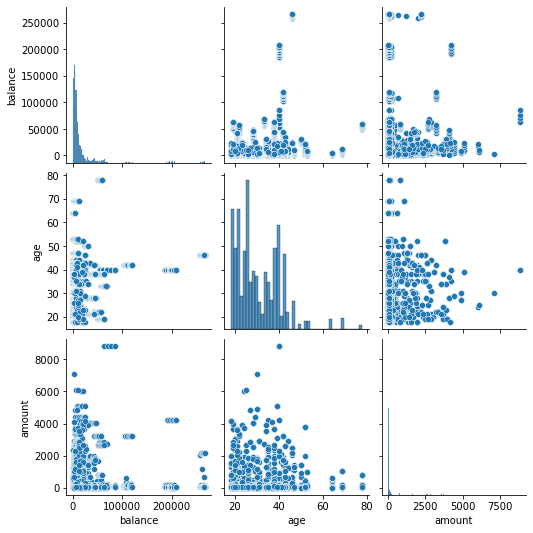

In [20]:
sns.pairplot(data) # Exploring the types of relationships across the column

In [21]:
#Salary calculation
data['trans_Month'] = pd.DatetimeIndex(data['date']).month
salary = data[(data['txn_description'] == 'PAY/SALARY')] # all salary transactions
salary= salary.pivot_table(index='customer_id',values='amount',aggfunc=np.sum) # suming the salary transtn for each cus
salary.reset_index(inplace=True)
salary['annual_salary'] = (round(salary['amount']*4,2)) # multiplying 3 months salary by 4 to get annual

salary.head()

,customer_id,amount,annual_salary
0,CUS-1005756958,12616.11,50464.44
1,CUS-1117979751,25050.55,100202.20
2,CUS-1140341822,11499.06,45996.24
3,CUS-1147642491,22248.07,88992.28
4,CUS-1196156254,27326.11,109304.44


In [22]:
salary = salary.drop(["amount"],axis =1)
salary.head()

,customer_id,annual_salary
0,CUS-1005756958,50464.44
1,CUS-1117979751,100202.20
2,CUS-1140341822,45996.24
3,CUS-1147642491,88992.28
4,CUS-1196156254,109304.44


In [23]:
#Expense Calculation
expenses = data[data['movement'] == 'debit']
expenses = expenses.pivot_table(index='customer_id',values='amount',aggfunc=np.sum)
expenses['Annual_Expense'] = round(expenses['amount']*4) # multiplying for annual expense
expenses.reset_index(inplace=True)
salary= pd.merge(salary,expenses[['customer_id','Annual_Expense']],on='customer_id', how='left') # Merging Expense& salary DF

In [24]:
salary.head()

,customer_id,annual_salary,Annual_Expense
0,CUS-1005756958,50464.44,14611.0
1,CUS-1117979751,100202.20,35735.0
2,CUS-1140341822,45996.24,22046.0
3,CUS-1147642491,88992.28,26931.0
4,CUS-1196156254,109304.44,34898.0


In [25]:
age_gender = data[['customer_id','age','gender']] # calling the age and gender table 
age_gender.drop_duplicates(inplace=True) # keeping only one age and gender record for each customer

In [26]:
salary = pd.merge(salary,age_gender[['customer_id','age']],on='customer_id', how='left') # mergning age
salary = pd.merge(salary,age_gender[['customer_id','gender']],on='customer_id', how='left') # mergning gender
#salary = pd.merge(salary,data[['customer_id','gender']],on='customer_id', how='left')

In [27]:
salary.head()

,customer_id,annual_salary,Annual_Expense,age,gender
0,CUS-1005756958,50464.44,14611.0,53,F
1,CUS-1117979751,100202.20,35735.0,21,M
2,CUS-1140341822,45996.24,22046.0,28,M
3,CUS-1147642491,88992.28,26931.0,34,F
4,CUS-1196156254,109304.44,34898.0,34,F


### Creating Extra Features

In [28]:
#Quick check on the average number of transactions across all customer and transaction
data[(data['movement'] == 'debit')]['amount'].mean()

52.57234318996403

In [29]:
#counting the no of trasnactions that is three times the average spend
large_trans = []
for id in unique_customer:
    count = 0
    trans = data.loc[data.customer_id == id, "amount"]
    for amount in trans:
        if amount > data[(data['movement'] == 'debit')]['amount'].mean()*3: #no of trans times 3 of the average
            count += 1
    large_trans.append(count)
large_trans[: 15]

[22, 19, 15, 17, 27, 15, 20, 7, 19, 19, 15, 12, 14, 17, 19]

In [30]:
max_spend = []
for id in unique_customer:
    trans = data[(data['movement'] == 'debit')]
    trans = data.loc[data.customer_id == id, "amount"]
    max_spend.append(max(trans))
max_spend[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

In [79]:
avg_trans = []
for id in unique_customer:
    trans = data.loc[data.customer_id == id, "amount"]
    avg_trans.append(trans.mean())
avg_trans[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

In [32]:
feature = pd.DataFrame({"customer_id":unique_customer, "large_trans":large_trans, "max_spend":max_spend,
                            "avg_trans":avg_trans})
feature.head()# putting the new features in a dataframe

,customer_id,large_trans,max_spend,avg_trans
0,CUS-2487424745,22,1452.21,45.348772
1,CUS-2142601169,19,2349.55,78.206106
2,CUS-1614226872,15,892.09,74.465019
3,CUS-2688605418,17,2320.30,159.304186
4,CUS-4123612273,27,1068.04,166.508358


In [33]:
salary = pd.merge(salary,feature[["customer_id","large_trans", "max_spend", "avg_trans"]],on='customer_id', how='left')
salary.head() # merging the two dataframes

,customer_id,annual_salary,Annual_Expense,age,gender,large_trans,max_spend,avg_trans
0,CUS-1005756958,50464.44,14611.0,53,F,18,970.47,222.862603
1,CUS-1117979751,100202.20,35735.0,21,M,13,3578.65,339.843700
2,CUS-1140341822,45996.24,22046.0,28,M,12,1916.51,212.632500
3,CUS-1147642491,88992.28,26931.0,34,F,26,1711.39,245.600169
4,CUS-1196156254,109304.44,34898.0,34,F,14,3903.73,147.145796


<AxesSubplot:xlabel='annual_salary', ylabel='Density'>

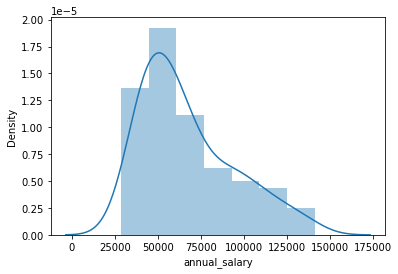

In [34]:
#checking the annual salary distribution
sns.distplot(salary['annual_salary'])

<AxesSubplot:>

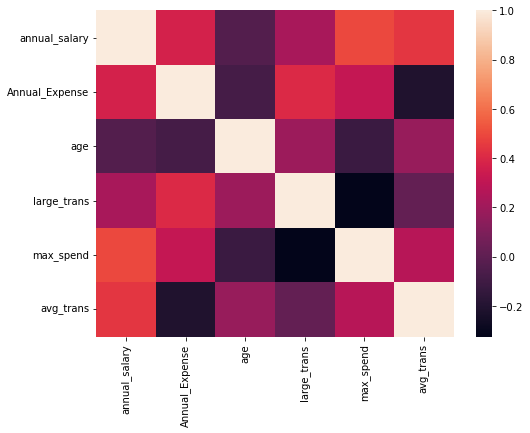

In [35]:
#Checking the relationship between the variables
plt.figure(figsize=(8, 6))
sns.heatmap(salary.corr())

Visualising  interesting correlations

Text(0, 0.5, 'Annual_Expense')

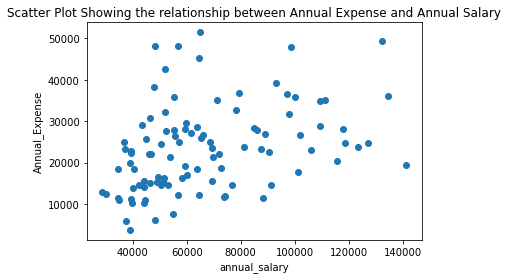

In [85]:
plt.scatter("annual_salary","Annual_Expense", data= salary)
plt.title("Scatter Plot Showing the relationship between Annual Expense and Annual Salary")
plt.xlabel('annual_salary')
plt.ylabel('Annual_Expense')

For most people, their spending is influenced by their income bracket.

Text(0, 0.5, 'age')

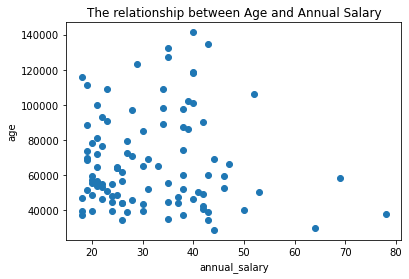

In [97]:
plt.scatter("age", "annual_salary", data= salary)
plt.title("The relationship between Age and Annual Salary")
plt.xlabel('annual_salary')
plt.ylabel('age')

Age has slight relationship with annual salary

In [87]:
salary.head()

,annual_salary,Annual_Expense,age,large_trans,max_spend,avg_trans,M
0,50464.44,14611.0,53,18,970.47,222.862603,0
1,100202.20,35735.0,21,13,3578.65,339.843700,1
2,45996.24,22046.0,28,12,1916.51,212.632500,1
3,88992.28,26931.0,34,26,1711.39,245.600169,0
4,109304.44,34898.0,34,14,3903.73,147.145796,0


Text(0, 0.5, 'large_trans')

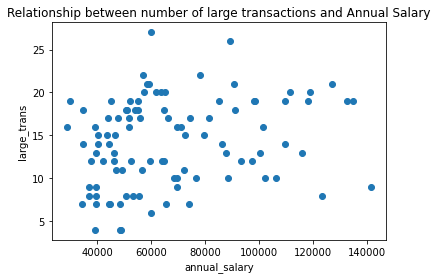

In [98]:
plt.scatter("annual_salary", "large_trans", data= salary)
plt.title("Relationship between number of large transactions and Annual Salary")
plt.xlabel('annual_salary')
plt.ylabel('large_trans')

Text(0, 0.5, 'max_spend')

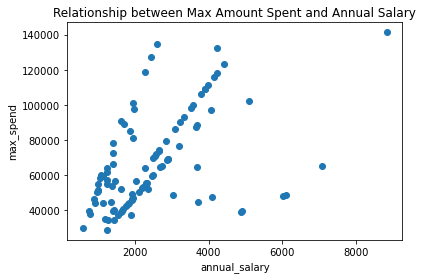

In [94]:
plt.scatter("max_spend", "annual_salary", data= salary)
plt.title("Relationship between Max Amount Spent and Annual Salary")
plt.xlabel('annual_salary')
plt.ylabel('max_spend')

### Final Data preparation

In [36]:
salary.head()

,customer_id,annual_salary,Annual_Expense,age,gender,large_trans,max_spend,avg_trans
0,CUS-1005756958,50464.44,14611.0,53,F,18,970.47,222.862603
1,CUS-1117979751,100202.20,35735.0,21,M,13,3578.65,339.843700
2,CUS-1140341822,45996.24,22046.0,28,M,12,1916.51,212.632500
3,CUS-1147642491,88992.28,26931.0,34,F,26,1711.39,245.600169
4,CUS-1196156254,109304.44,34898.0,34,F,14,3903.73,147.145796


In [37]:
#converting the gender column to a numbers readable by SKlearn
sex = pd.get_dummies(salary['gender'], drop_first = True)
sex.head(3)

,M
0,0
1,1
2,1


In [38]:
salary = pd.concat([salary, sex], axis =1) # merging the gender column with salary df
salary.head()

,customer_id,annual_salary,Annual_Expense,age,gender,large_trans,max_spend,avg_trans,M
0,CUS-1005756958,50464.44,14611.0,53,F,18,970.47,222.862603,0
1,CUS-1117979751,100202.20,35735.0,21,M,13,3578.65,339.843700,1
2,CUS-1140341822,45996.24,22046.0,28,M,12,1916.51,212.632500,1
3,CUS-1147642491,88992.28,26931.0,34,F,26,1711.39,245.600169,0
4,CUS-1196156254,109304.44,34898.0,34,F,14,3903.73,147.145796,0


Explore correlations between annual salary and various customer attributes (e.g. age). 

### Building the Model

Using Linear Regression

In [39]:
salary.drop(['customer_id','gender'],axis=1,inplace=True)

In [40]:
X = salary.drop(["annual_salary"], axis = 1)
y= salary[["annual_salary"]]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=101)

In [42]:
lm = LinearRegression()

In [43]:
lm.fit(X_train,y_train)

LinearRegression()

In [44]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [[ 5.85037792e-01 -1.89272332e+02  1.13042086e+03  6.39828354e+00
   8.17984053e+01  4.66763119e+03]]


### Predicting Test Data
Now that we have fit our model, let's evaluate its performance by predicting off the test values!

In [46]:
predictions = lm.predict( X_test)

Text(0, 0.5, 'Predicted Y')

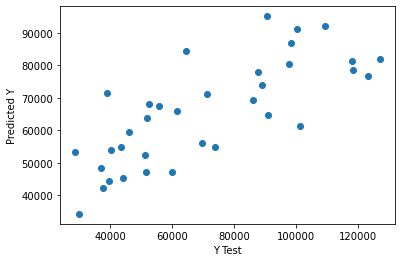

In [47]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

Let's evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2).

The Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error.

In [48]:
# calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 16397.375736530983
MSE: 426623191.2067364
RMSE: 20654.85877963673


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
print('Coefficient of determination: ', r2_score(y_test, predictions))

Coefficient of determination:  0.493951001970132


### Decision Tree

In [109]:
dtree = DecisionTreeRegressor()
#dtree_pipeline = make_pipeline(column_transform, tree)

In [110]:
dtree.fit(X_train,y_train)

DecisionTreeRegressor()

In [111]:
predictions = dtree.predict(X_test)

In [118]:
print('Coefficient of determination: ', r2_score(y_test, predictions))

Coefficient of determination:  0.18464842132231296


In [120]:
print("RMSE: ", round(np.sqrt(mean_squared_error(predictions, y_test))))

RMSE:  26218


### Finding

The accurancy of the linear regression model is 49% (which is way better than the 18% accuracy of decision tree) but it has an rmse value of 20656 a little better than decison treet. The data available is not sufficiently reliable to predict employers salary accurately. 

Let's see if we can improve the accuracy if we train more features - features available is the merchant state and merchant Surburbs



##More data is required to develop a more reliable model.

In [66]:
location = data[['customer_id','merchant_suburb','merchant_state']]
location.drop_duplicates(subset =["customer_id"], inplace=True)

In [70]:
location.isna().sum()

customer_id         0
merchant_suburb    43
merchant_state     43
dtype: int64

### Conculsion
Attempt to train more features proved frutile as the two other relevant columns have 43 missing values. Therefore more data is required to build an accurate predictive model.